# **Part A**
Count / Frequency based Naive Bayes Classifier

Accuracy: 0.7702339472374315
F1 Score: 0.7065774691521487

Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.60      0.59      0.59      3621
 CONCLUSIONS       0.66      0.72      0.69      4571
     METHODS       0.84      0.87      0.85      9897
   OBJECTIVE       0.59      0.54      0.56      2333
     RESULTS       0.87      0.82      0.84      9713

    accuracy                           0.77     30135
   macro avg       0.71      0.71      0.71     30135
weighted avg       0.77      0.77      0.77     30135

Confusion Matrix:
 [[2127  636  285  537   36]
 [ 507 3286  130  154  494]
 [ 256  197 8629  158  657]
 [ 615  251  203 1249   15]
 [  67  635 1062   29 7920]]


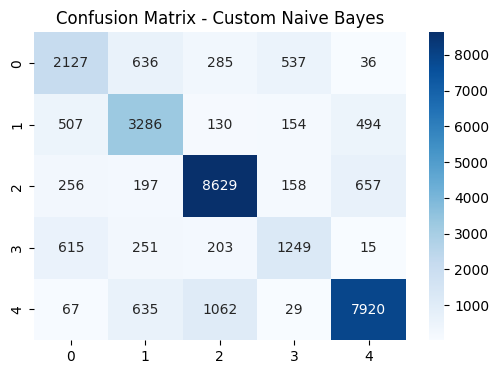

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# ============================================
# Data loading function (DO NOT CHANGE)
# ============================================
def load_pubmed_rct_file(filepath):
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# ============================================
# Naive Bayes From Scratch
# ============================================
class NaiveBayesClassifier:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # Log prior
            self.class_priors[c] = np.log(X_c.shape[0] / X_counts.shape[0])

            # Count sum of words in class
            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # Laplace smoothing
            numerator = feature_sum + self.alpha
            denominator = total_mass + (self.alpha * self.vocabulary_size)

            # Log likelihoods
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            x_i = X_counts.getrow(i)
            scores = {}

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_index = x_i.indices
                non_zero_val = x_i.data

                # Add ∑ count(w) * log(P(w|C))
                log_prob += np.sum(non_zero_val * log_likelihoods[non_zero_index])
                scores[c] = log_prob

            predicted_class = max(scores, key=scores.get)
            y_pred.append(predicted_class)

        return np.array(y_pred)


# ============================================
# Load Dataset (TODO completed)
# ============================================
train_df = load_pubmed_rct_file("/content/train.txt")
dev_df   = load_pubmed_rct_file("/content/dev.txt")
test_df  = load_pubmed_rct_file("/content/test.txt")

# ============================================
# Vectorization
# ============================================
vectorizer = CountVectorizer(lowercase=True, stop_words=None)
X_train = vectorizer.fit_transform(train_df["sentence"])
X_dev   = vectorizer.transform(dev_df["sentence"])
X_test  = vectorizer.transform(test_df["sentence"])

# ============================================
# Train custom NB model
# ============================================
nb_model = NaiveBayesClassifier(alpha=1.0)
nb_model.fit(X_train, train_df["label"])

# ============================================
# Predictions
# ============================================
y_pred = nb_model.predict(X_test)

# ============================================
# Metrics
# ============================================
print("Accuracy:", accuracy_score(test_df["label"], y_pred))
print("F1 Score:", f1_score(test_df["label"], y_pred, average="macro"))
print("\nClassification Report:\n", classification_report(test_df["label"], y_pred))

cm = confusion_matrix(test_df["label"], y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Custom Naive Bayes")
plt.show()


In [8]:
# Load and Prepare Data (DO NOT CHANGE FILE PATHS)
dir_path = '/content/'

try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']

    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print("❌ Dataset file not found. Upload train.txt, dev.txt, test.txt to /content/")


Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [9]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        # Using unigrams + bigrams for better context
        ngram_range=(1, 2),
        # Ignore extremely rare words
        min_df=2
    )

    print("Fitting Count Vectorizer and transforming training data...")
    # Fit vectorizer on training data & transform
    X_train_counts = count_vectorizer.fit_transform(X_train)
    print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    # Transform X_test using the same vectorizer
    X_test_counts = count_vectorizer.transform(X_test)

    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")

    # Initialize the custom NaiveBayesClassifier
    nb_model = NaiveBayesClassifier(alpha=1.0)

    # Fit on training data
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")


Fitting Count Vectorizer and transforming training data...
Vocabulary size: 301234
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [10]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

# Predict y_test_pred using X_test_counts
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")



=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7571
              precision    recall  f1-score   support

  BACKGROUND       0.57      0.56      0.57      3621
 CONCLUSIONS       0.63      0.69      0.66      4571
     METHODS       0.81      0.89      0.85      9897
   OBJECTIVE       0.60      0.43      0.50      2333
     RESULTS       0.87      0.80      0.84      9713

    accuracy                           0.76     30135
   macro avg       0.70      0.68      0.68     30135
weighted avg       0.76      0.76      0.75     30135

Macro-averaged F1 score: 0.6825


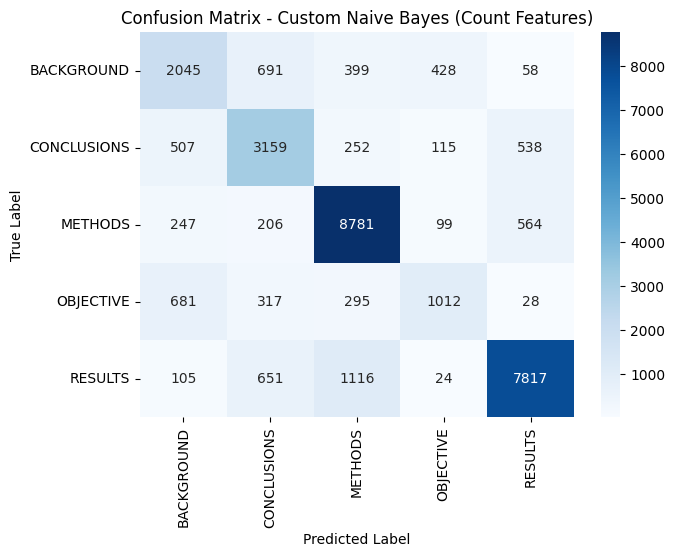

In [11]:
# Confusion Matrix on test set
    # // TODO: Use the confusion_matrix, matplotlib, and seaborn libraries to generate
    # a visual confusion matrix (heatmap) for the predicted results.
    # if y_test_pred is not None:
    #     cm = confusion_matrix(...)
    #     plt.figure(...)
    #     sns.heatmap(...)
    #     plt.show()
    # Confusion Matrix on test set
if y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred, labels=target_names)

    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)

    plt.title("Confusion Matrix - Custom Naive Bayes (Count Features)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
else:
    print("Confusion Matrix cannot be generated — predictions missing.")


# **Part B**
TF-IDF score based Classifier

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Define a Pipeline using TfidfVectorizer and MultinomialNB
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words='english',
        strip_accents='unicode'
    )),
    ("nb", MultinomialNB())
])

# Train the initial pipeline on the training set
print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")

# Predict and evaluate on the test set
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(classification_report(y_test, y_test_pred, target_names=target_names))
print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")

# Hyperparameter Tuning using GridSearchCV
param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2), (1,3)],
    "tfidf__min_df": [1, 2, 5],
    "nb__alpha": [0.1, 0.5, 1.0]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

print("\nStarting Hyperparameter Tuning on Development Set...")
grid.fit(X_dev, y_dev)
print("Grid search complete.")

# Print best parameters and best score
print("\n=== Best Hyperparameters (Grid Search) ===")
print(grid.best_params_)
print(f"Best Dev F1 Score: {grid.best_score_:.4f}")


Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.6996
              precision    recall  f1-score   support

  BACKGROUND       0.61      0.37      0.46      3621
 CONCLUSIONS       0.61      0.55      0.57      4571
     METHODS       0.68      0.88      0.77      9897
   OBJECTIVE       0.72      0.09      0.16      2333
     RESULTS       0.77      0.85      0.81      9713

    accuracy                           0.70     30135
   macro avg       0.68      0.55      0.56     30135
weighted avg       0.69      0.70      0.67     30135

Macro-averaged F1 score: 0.5555

Starting Hyperparameter Tuning on Development Set...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Grid search complete.

=== Best Hyperparameters (Grid Search) ===
{'nb__alpha': 0.1, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}
Best Dev F1 Score: 0.6308


# **Part C**
Bayes Optimal Classifier

Part C Draft

Please enter your full SRN (e.g., PES1UG22CS345): PES2UG23CS354
Using dynamic sample size: 10354
Actual sampled training set size used: 10354

Training all base models...
All base models trained.

Posterior Weights (P(h|D)): [5.81716648e-068 1.00000000e+000 3.23320841e-074 5.92878775e-323
 0.00000000e+000]

Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.7090
Macro F1 Score: 0.6148

Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.56      0.37      0.45      3621
 CONCLUSIONS       0.61      0.56      0.58      4571
     METHODS       0.71      0.89      0.79      9897
   OBJECTIVE       0.66      0.35      0.45      2333
     RESULTS       0.80      0.81      0.80      9713

    accuracy                           0.71     30135
   macro avg       0.66      0.60      0.61     30135
weighted avg       0.70      0

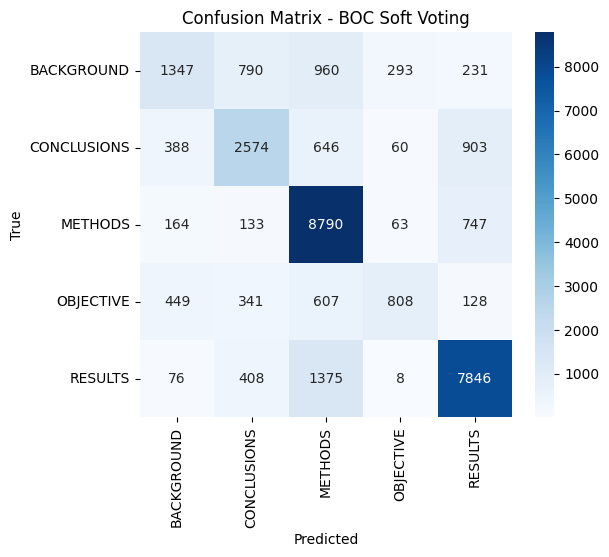

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# =======================================================
# Dynamic Data Sampling (DO NOT CHANGE)
# =======================================================
BASE_SAMPLE_SIZE = 10000

FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except:
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value
print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Placeholder data if missing
if 'X_train' not in globals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one"] * 11000)
    y_train = pd.Series(["BACKGROUND"] * 5000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")

# =======================================================
# Define Base Learners (DO NOT CHANGE)
# =======================================================
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'min_df': 5
}

h1_nb = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)), ('clf', MultinomialNB(alpha=1.0, fit_prior=False))])
h2_lr = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)), ('clf', LogisticRegression(solver='liblinear', max_iter=1000, random_state=42))])
h3_rf = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)), ('clf', CalibratedClassifierCV(RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42), cv=3, method='isotonic'))])
h4_dt = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)), ('clf', CalibratedClassifierCV(DecisionTreeClassifier(max_depth=10, random_state=42), cv=3, method='isotonic'))])
h5_knn = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)), ('clf', CalibratedClassifierCV(KNeighborsClassifier(n_neighbors=5), cv=3, method='isotonic'))])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']

# =======================================================
# ✅ Train Base Models
# =======================================================
print("\nTraining all base models...")
for model in hypotheses:
    model.fit(X_train_sampled, y_train_sampled)
print("All base models trained.")

# =======================================================
# ✅ Compute Posterior Weights
# =======================================================
X_sub, X_val, y_sub, y_val = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.2, random_state=42, stratify=y_train_sampled
)

log_likelihoods = []
eps = 1e-12

for model in hypotheses:
    model.fit(X_sub, y_sub)
    probs = model.predict_proba(X_val)
    classes = model.classes_
    idx = {c: i for i, c in enumerate(classes)}

    true_probs = np.array([probs[i][idx[y]] if y in idx else eps for i, y in enumerate(y_val)])
    log_likelihood = np.sum(np.log(true_probs + eps))
    log_likelihoods.append(log_likelihood)

shifted = np.array(log_likelihoods) - np.max(log_likelihoods)
exp_vals = np.exp(shifted)
posterior_weights = exp_vals / np.sum(exp_vals)

print("\nPosterior Weights (P(h|D)):", posterior_weights)

# =======================================================
# ✅ Voting Classifier (BOC Approximation)
# =======================================================
estimators = list(zip(hypothesis_names, hypotheses))

from sklearn.ensemble import VotingClassifier
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights
)

print("\nFitting the VotingClassifier (BOC approximation)...")
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")

# =======================================================
# ✅ Final Prediction on Test Set
# =======================================================
print("\nPredicting on test set...")
y_pred = boc_soft_voter.predict(X_test)

print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Accuracy: {acc:.4f}")
print(f"Macro F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - BOC Soft Voting")
plt.show()
